<a href="https://colab.research.google.com/github/hieuledinh/Pneumonia-Detection-with-Deep-Learning-using-CNNs/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install texttable

In [ ]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from texttable import Texttable

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!python3 --version

Python 3.10.12


In [ ]:
MODEL_LOC = '/content/drive/MyDrive/pneumonia_data/model_data/pneumonia_detection_cnn_model_data.h5'
DATA_DIR = '/content/drive/MyDrive/pneumonia_data/data_chest_xray/'
TRAINING_DATA_DIR = DATA_DIR + '/train/'
TEST_DATA_DIR = DATA_DIR + '/test/'
VAL_DATA_DIR = DATA_DIR + '/val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
DATA_DIR_VAL = '/content/drive/MyDrive/pneumonia_data/chest_xray/'
TRAINING_DATA_DIR_VAL = DATA_DIR_VAL + '/train/'
TEST_DATA_DIR_VAL = DATA_DIR_VAL + '/test/'
VAL_DATA_DIR_VAL = DATA_DIR_VAL + '/val/'


In [ ]:
# counting the number of images for every dataset and the associated two classes (Normal and Pneumonia)
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

t = Texttable()

t.add_rows([['Dataset Type', 'Normal', 'Pneumonia'],
            ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')],
            ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
            ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')]
           ])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1106   | 3392      |
+--------------+--------+-----------+
| Test         | 317    | 971       |
+--------------+--------+-----------+
| Validation   | 160    | 486       |
+--------------+--------+-----------+


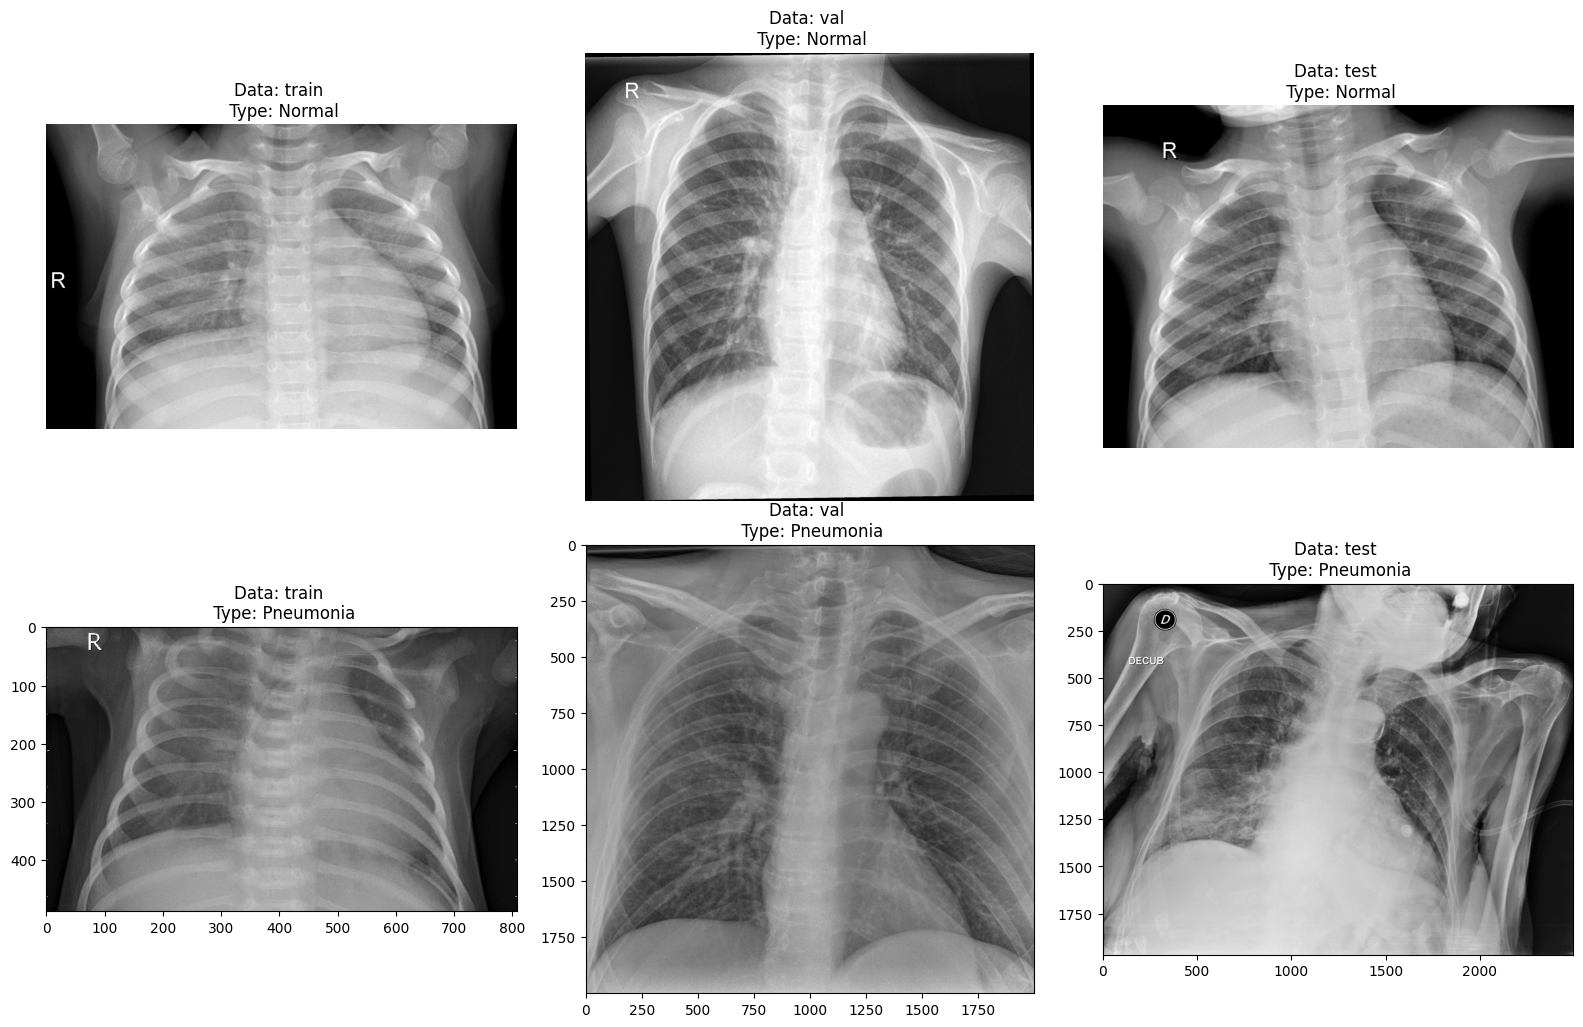

In [ ]:
# Looking at one image per class in each dataset type
fig, ax = plt.subplots(2, 3, figsize = (16, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['train', 'val', 'test']):
    image_path = DATA_DIR + subdir
    ax[i].imshow(plt.imread(image_path + '/NORMAL/' + os.listdir(image_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(subdir), fontsize = 12)
    ax[i].axis('off')
    ax[i+3].imshow(plt.imread(image_path + '/PNEUMONIA/' + os.listdir(image_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(subdir), fontsize = 12)

In [ ]:
# data generator on training dataset, data augmentation applied
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(224, 224))

# data generator on test dataset, data augmentation not applied
# used as validation dataset as the val dir contains only 16 images
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset (used as validation)
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                target_size=(224, 224))

# data generator on validation dataset, data augmentation not applied
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset = test_datagen.flow_from_directory(VAL_DATA_DIR,
                                               classes=DETECTION_CLASSES,
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224))

Found 4498 images belonging to 2 classes.
Found 1288 images belonging to 2 classes.
Found 646 images belonging to 2 classes.


In [ ]:
# printing the assigned indices for sanity check
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 112, 112, 32)      688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 112, 112, 32)      1344      
 bleConv2D)                                                      
                                                        

In [ ]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

NameError: name 'cnn_model' is not defined

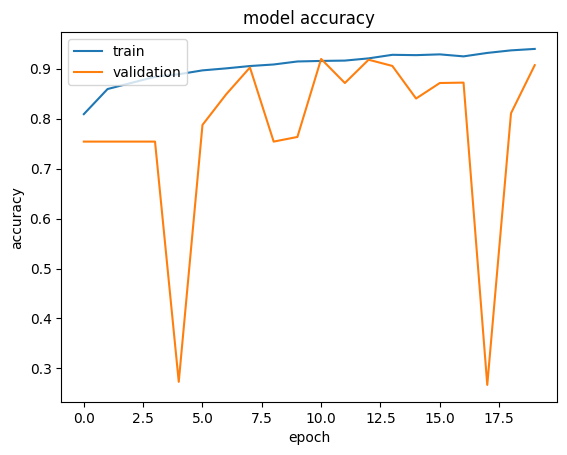

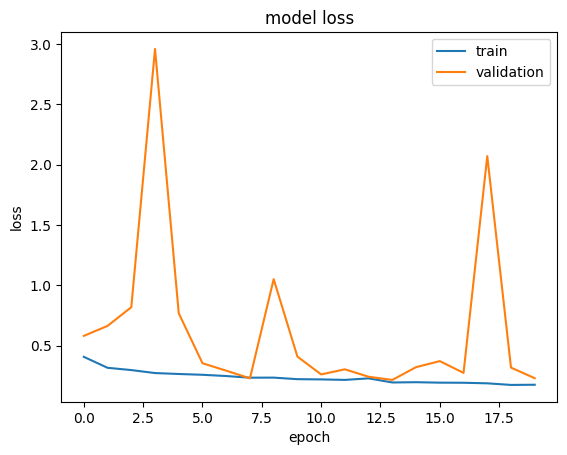

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
evaluation = cnn_model.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = cnn_model.evaluate(training_dataset)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

41/41 [==============================] - 21s 495ms/step - loss: 0.2298 - accuracy: 0.9068
Test Accuracy: 90.68%
141/141 [==============================] - 126s 892ms/step - loss: 0.1883 - accuracy: 0.9240
Train Accuracy: 92.40%


# VGG16


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D


vgg16_base_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_model = Sequential()
vgg16_model.add(vgg16_base_model)
vgg16_model.add(GlobalAveragePooling2D())

# vgg16_model.add(Flatten())
vgg16_model.add(Dense(units=512, activation='relu'))
vgg16_model.add(Dropout(0.6))
vgg16_model.add(Dense(units=128, activation='relu'))
vgg16_model.add(Dropout(0.4))
vgg16_model.add(Dense(units=64, activation='relu'))
vgg16_model.add(Dropout(0.3))

#  Softmax Classifier
vgg16_model.add(Dense(2, activation='softmax'))
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [ ]:
MODEL_LOC_VGG16 = '/content/drive/MyDrive/pneumonia_data/model_data/pneumonia_detection_vgg16_model_data.h5'


In [ ]:
# introducing callbacks
early_stop_vgg16 = EarlyStopping(monitor='val_loss',
                           patience=5,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_vgg16 = ModelCheckpoint(filepath=MODEL_LOC_VGG16,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
vgg16_model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history_vgg16 = vgg16_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop_vgg16, checkpoint_vgg16],
                        verbose=1)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7401

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 1757s 12s/step - loss: 0.6175 - accuracy: 0.7401 - val_loss: 0.5743 - val_accuracy: 0.7539
Epoch 2/20
141/141 [==============================] - 156s 1s/step - loss: 0.5733 - accuracy: 0.7534 - val_loss: 0.5742 - val_accuracy: 0.7539
Epoch 3/20
141/141 [==============================] - 154s 1s/step - loss: 0.5831 - accuracy: 0.7528 - val_loss: 0.5721 - val_accuracy: 0.7539
Epoch 4/20
141/141 [==============================] - 156s 1s/step - loss: 0.5795 - accuracy: 0.7508 - val_loss: 0.5565 - val_accuracy: 0.7539
Epoch 5/20
141/141 [==============================] - 148s 1s/step - loss: 0.5770 - accuracy: 0.7492 - val_loss: 0.5669 - val_accuracy: 0.7539
Epoch 6/20
141/141 [==============================] - 148s 1s/step - loss: 0.5619 - accuracy: 0.7541 - val_loss: 0.5583 - val_accuracy: 0.7539
Epoch 7/20
141/141 [==============================] - 147s 1s/step - loss: 0.5591 - accuracy: 0.7541 - val_loss: 0.5580 - val_accuracy: 0.7539
Epoch 8/

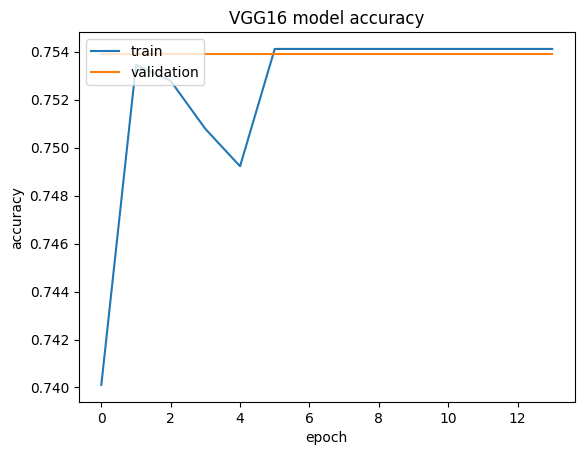

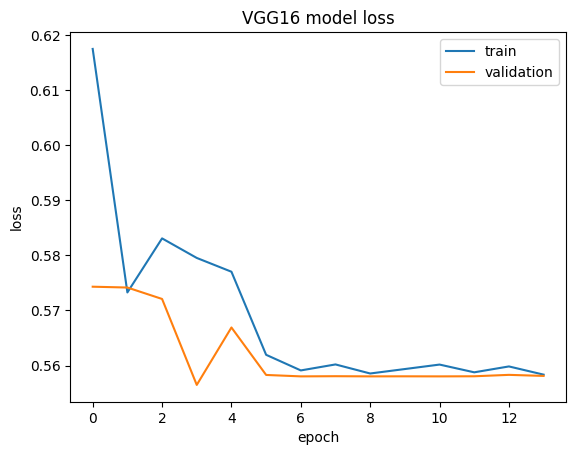

In [ ]:
#  "Accuracy"
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# VGG16 Ver2

In [ ]:
for layer in vgg16_base_model.layers:
    layer.trainable = False

In [ ]:
MODEL_LOC_VGG16 = '/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_model_data.hdf5'

In [ ]:
# introducing callbacks
early_stop_vgg16 = EarlyStopping(monitor='val_loss',
                           patience=5,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_vgg16 = ModelCheckpoint(filepath=MODEL_LOC_VGG16,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
step_train = training_dataset.n//BATCH_SIZE
step_val = val_dataset.n//BATCH_SIZE

In [ ]:
vgg16_model_2 = Sequential()
vgg16_model_2.add(vgg16_base_model)
vgg16_model_2.add(GlobalAveragePooling2D())

vgg16_model_2.add(Flatten())
vgg16_model_2.add(Dense(units=512, activation='relu'))
vgg16_model_2.add(BatchNormalization())
vgg16_model_2.add(Dropout(0.5))
vgg16_model_2.add(Dense(units=128, activation='relu'))
vgg16_model_2.add(BatchNormalization())
vgg16_model_2.add(Dropout(0.4))
vgg16_model_2.add(Dense(units=64, activation='relu'))
vgg16_model_2.add(BatchNormalization())
vgg16_model_2.add(Dropout(0.3))

# vgg16_model2.add(Dense(units=128, activation='relu'))
# vgg16_model2.add(Dropout(0.2))
# vgg16_model2.add(Dense(units=64, activation='relu'))
# vgg16_model2.add(Dropout(0.1))

#  Softmax Classifier
vgg16_model_2.add(Dense(2, activation='softmax'))
vgg16_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
vgg16_model_2.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history_vgg16_2 = vgg16_model_2.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_vgg16, checkpoint_vgg16],
                        verbose=1)
vgg16_model_2.save("/content/drive/MyDrive/pneumonia_data/model_data/pneumonia_detection_vgg16_2_model_data.h5")

Epoch 1/5
140/140 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8059

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 1565s 11s/step - loss: 0.5098 - accuracy: 0.8059 - val_loss: 0.4241 - val_accuracy: 0.7547
Epoch 2/5
140/140 [==============================] - 129s 922ms/step - loss: 0.3085 - accuracy: 0.8831 - val_loss: 0.3872 - val_accuracy: 0.7906
Epoch 3/5
140/140 [==============================] - 130s 929ms/step - loss: 0.2660 - accuracy: 0.8966 - val_loss: 0.2368 - val_accuracy: 0.9125
Epoch 4/5
140/140 [==============================] - 131s 934ms/step - loss: 0.2448 - accuracy: 0.9082 - val_loss: 0.2360 - val_accuracy: 0.9141
Epoch 5/5
140/140 [==============================] - 139s 995ms/step - loss: 0.2327 - accuracy: 0.9092 - val_loss: 0.3972 - val_accuracy: 0.8562


In [ ]:
import tensorflow as tf

In [ ]:
from keras.models import Model, load_model

In [ ]:
vgg16_load_model = tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/pneumonia_detection_vgg16_2_model_data.h5")

In [ ]:
vgg16_load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
history_vgg16_model_load = vgg16_load_model.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_vgg16, checkpoint_vgg16],
                        verbose=1)
vgg16_load_model.save("/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_model_data(10epochs).h5")

Epoch 1/5
140/140 [==============================] - 142s 985ms/step - loss: 0.2335 - accuracy: 0.9093 - val_loss: 0.2376 - val_accuracy: 0.9156
Epoch 2/5
140/140 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9167

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 130s 929ms/step - loss: 0.2115 - accuracy: 0.9167 - val_loss: 0.1945 - val_accuracy: 0.9234
Epoch 3/5
140/140 [==============================] - 128s 917ms/step - loss: 0.2034 - accuracy: 0.9214 - val_loss: 0.1946 - val_accuracy: 0.9203
Epoch 4/5
140/140 [==============================] - 129s 920ms/step - loss: 0.2108 - accuracy: 0.9174 - val_loss: 0.1942 - val_accuracy: 0.9328
Epoch 5/5
140/140 [==============================] - 130s 928ms/step - loss: 0.1905 - accuracy: 0.9290 - val_loss: 0.2037 - val_accuracy: 0.9187


In [ ]:
vgg16_20epochs = tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_model_data(10epochs).h5")

In [ ]:
MODEL_LOC_VGG16 = '/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_20epochs.hdf5'

In [ ]:
history_vgg16_20epochs = vgg16_20epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=10,
                        callbacks=[early_stop_vgg16, checkpoint_vgg16],
                        verbose=1)
vgg16_20epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_model_data(20epochs).h5")

Epoch 1/10
140/140 [==============================] - 128s 911ms/step - loss: 0.1884 - accuracy: 0.9297 - val_loss: 0.2032 - val_accuracy: 0.9312
Epoch 2/10
140/140 [==============================] - 127s 904ms/step - loss: 0.1965 - accuracy: 0.9243 - val_loss: 0.2280 - val_accuracy: 0.9141
Epoch 3/10
140/140 [==============================] - 127s 906ms/step - loss: 0.1888 - accuracy: 0.9232 - val_loss: 0.2821 - val_accuracy: 0.9047
Epoch 4/10
140/140 [==============================] - 127s 904ms/step - loss: 0.1972 - accuracy: 0.9221 - val_loss: 0.2055 - val_accuracy: 0.9312
Epoch 5/10
140/140 [==============================] - 126s 901ms/step - loss: 0.1822 - accuracy: 0.9295 - val_loss: 0.2750 - val_accuracy: 0.8953
Epoch 6/10
140/140 [==============================] - 127s 909ms/step - loss: 0.1818 - accuracy: 0.9270 - val_loss: 0.1978 - val_accuracy: 0.9266
Epoch 7/10
140/140 [==============================] - 129s 923ms/step - loss: 0.1816 - accuracy: 0.9306 - val_loss: 0.2858 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


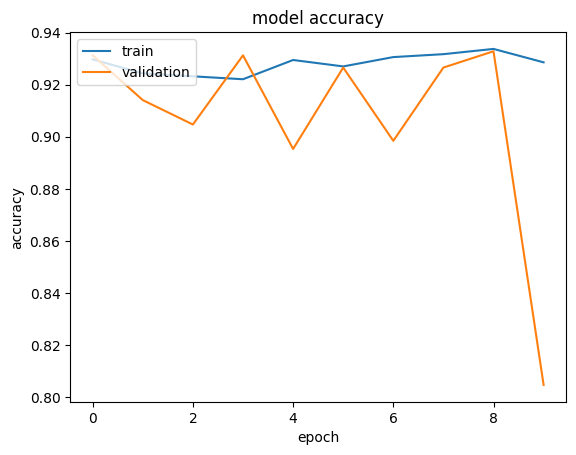

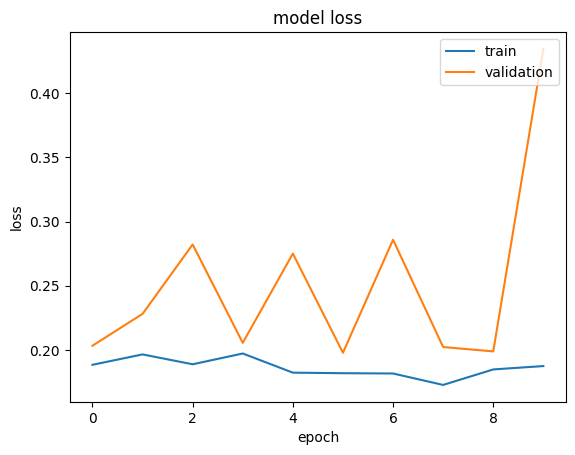

In [ ]:
#  "Accuracy"
plt.plot(history_vgg16_20epochs.history['accuracy'])
plt.plot(history_vgg16_20epochs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_vgg16_20epochs.history['loss'])
plt.plot(history_vgg16_20epochs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluation

In [ ]:
evaluation_vgg16 = vgg16_20epochs.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation_vgg16[1] * 100:.2f}%")

evaluation_vgg16 = vgg16_20epochs.evaluate(training_dataset)
print(f"Train Accuracy: {evaluation_vgg16[1] * 100:.2f}%")

41/41 [==============================] - 19s 459ms/step - loss: 0.5112 - accuracy: 0.8005
Test Accuracy: 80.05%
141/141 [==============================] - 118s 838ms/step - loss: 0.2313 - accuracy: 0.8995
Train Accuracy: 89.95%


# Validation By Data 1

In [ ]:
vgg16_20epochs = tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/vgg16_2_model_data(10epochs).h5")

## Data Val

In [ ]:
DATA_DIR_VAL = '/content/drive/MyDrive/pneumonia_data/chest_xray/'
TRAINING_DATA_DIR_VAL = DATA_DIR_VAL + '/train/'
TEST_DATA_DIR_VAL = DATA_DIR_VAL + '/test/'
VAL_DATA_DIR_VAL = DATA_DIR_VAL + '/val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')

In [ ]:
train_datagen_val = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset_val = train_datagen_val.flow_from_directory(TRAINING_DATA_DIR_VAL,
                                                     classes=DETECTION_CLASSES,
                                                     target_size=(224, 224))

# data generator on test dataset, data augmentation not applied
# used as validation dataset as the val dir contains only 16 images
test_datagen_val = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset (used as validation)
test_dataset_val = test_datagen_val.flow_from_directory(TEST_DATA_DIR_VAL,
                                                classes=DETECTION_CLASSES,
                                                target_size=(224, 224))

# data generator on validation dataset, data augmentation not applied
val_datagen_val = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset_val = val_datagen_val.flow_from_directory(VAL_DATA_DIR_VAL,
                                               classes=DETECTION_CLASSES,
                                               target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

t = Texttable()

t.add_rows([['Dataset Type', 'Normal', 'Pneumonia'],
            ['Training', count_images(TRAINING_DATA_DIR_VAL, 'NORMAL'), count_images(TRAINING_DATA_DIR_VAL, 'PNEUMONIA')],
            ['Test', count_images(TEST_DATA_DIR_VAL, 'NORMAL'), count_images(TEST_DATA_DIR_VAL, 'PNEUMONIA')],
            ['Validation', count_images(VAL_DATA_DIR_VAL, 'NORMAL'), count_images(VAL_DATA_DIR_VAL, 'PNEUMONIA')]
           ])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1341   | 3875      |
+--------------+--------+-----------+
| Test         | 234    | 390       |
+--------------+--------+-----------+
| Validation   | 8      | 8         |
+--------------+--------+-----------+


In [ ]:
evaluation_vgg16_val = vgg16_20epochs.evaluate(test_dataset_val)
print(f"Test Accuracy: {evaluation_vgg16_val[1] * 100:.2f}%")

evaluation_vgg16_val = vgg16_20epochs.evaluate(training_dataset_val)
print(f"Train Accuracy: {evaluation_vgg16_val[1] * 100:.2f}%")

evaluation_vgg16_val = vgg16_20epochs.evaluate(val_dataset_val)
print(f"Val Accuracy: {evaluation_vgg16_val[1] * 100:.2f}%")

20/20 [==============================] - 7s 340ms/step - loss: 0.2092 - accuracy: 0.9054
Test Accuracy: 90.54%
163/163 [==============================] - 2491s 15s/step - loss: 0.1538 - accuracy: 0.9446
Train Accuracy: 94.46%
1/1 [==============================] - 0s 357ms/step - loss: 0.6354 - accuracy: 0.7500
Val Accuracy: 75.00%


# RESNET

In [ ]:
import tensorflow as tf

In [ ]:
from keras.models import Model, load_model

In [ ]:
from keras.applications import ResNet50

# resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')
resnet_base_model = ResNet50(input_shape=[224,224] + [3], weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from keras.models import Model, load_model

In [ ]:
for layer in resnet_base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(resnet_base_model.output)

In [ ]:
prediction = Dense(2, activation='softmax')(x)

# creating a model object
model_resnet = Model(inputs=resnet_base_model.input, outputs=prediction)

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
MODEL_LOC_RESNET = '/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(5epochs).hdf5'


In [ ]:
# introducing callbacks
early_stop_resnet = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_resnet = ModelCheckpoint(filepath=MODEL_LOC_RESNET,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

NameError: name 'MODEL_LOC_RESNET' is not defined

In [ ]:
model_resnet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:

# fit the model
history_resnet = model_resnet.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=EPOCHS,
                        callbacks=[early_stop_resnet, checkpoint_resnet],
                        verbose=1)

NameError: name 'step_train' is not defined

In [ ]:
step_train = training_dataset.n//BATCH_SIZE
step_val = val_dataset.n//BATCH_SIZE

In [ ]:

# fit the model
history_resnet = model_resnet.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_resnet, checkpoint_resnet],
                        verbose=1)
model_resnet.save("/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(5epochs).h5")

Epoch 1/5
140/140 [==============================] - ETA: 0s - loss: 1.2567 - accuracy: 0.7548

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 1479s 10s/step - loss: 1.2567 - accuracy: 0.7548 - val_loss: 0.3084 - val_accuracy: 0.8859
Epoch 2/5
140/140 [==============================] - 1203s 9s/step - loss: 0.5115 - accuracy: 0.7962 - val_loss: 0.4326 - val_accuracy: 0.8234
Epoch 3/5
140/140 [==============================] - 1204s 9s/step - loss: 0.3579 - accuracy: 0.8462 - val_loss: 0.2580 - val_accuracy: 0.8969
Epoch 4/5
140/140 [==============================] - 1260s 9s/step - loss: 0.3959 - accuracy: 0.8430 - val_loss: 0.6238 - val_accuracy: 0.7547
Epoch 5/5
140/140 [==============================] - 1260s 9s/step - loss: 0.3989 - accuracy: 0.8406 - val_loss: 0.9324 - val_accuracy: 0.7516


In [ ]:
model_resnet_15epochs= tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(5epochs).h5")

In [ ]:
MODEL_LOC_RESNET_15epochs = '/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(15epochs).hdf5'

In [ ]:
# introducing callbacks
early_stop_resnet = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_resnet = ModelCheckpoint(filepath=MODEL_LOC_RESNET_15epochs,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history_resnet_15epochs = model_resnet_15epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=10,
                        callbacks=[early_stop_resnet, checkpoint_resnet],
                        verbose=1)
model_resnet_15epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(15epochs).h5")

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8683

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 1559s 11s/step - loss: 0.3509 - accuracy: 0.8683 - val_loss: 0.3363 - val_accuracy: 0.8594
Epoch 2/10
140/140 [==============================] - 135s 962ms/step - loss: 0.3418 - accuracy: 0.8594 - val_loss: 0.2437 - val_accuracy: 0.9078
Epoch 3/10
140/140 [==============================] - 135s 961ms/step - loss: 0.3760 - accuracy: 0.8589 - val_loss: 0.9469 - val_accuracy: 0.7516
Epoch 4/10
140/140 [==============================] - 133s 951ms/step - loss: 0.3536 - accuracy: 0.8641 - val_loss: 0.4439 - val_accuracy: 0.8078
Epoch 5/10
140/140 [==============================] - 136s 972ms/step - loss: 0.3543 - accuracy: 0.8665 - val_loss: 0.2962 - val_accuracy: 0.8813
Epoch 6/10
140/140 [==============================] - 134s 954ms/step - loss: 0.3567 - accuracy: 0.8623 - val_loss: 0.2114 - val_accuracy: 0.9156
Epoch 7/10
140/140 [==============================] - 134s 955ms/step - loss: 0.3660 - accuracy: 0.8554 - val_loss: 0.4042 - val_accurac

In [ ]:
model_resnet_20epochs= tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(15epochs).h5")

In [ ]:
MODEL_LOC_RESNET_20epochs = '/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(20epochs).hdf5'

In [ ]:
# introducing callbacks
early_stop_resnet = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_resnet = ModelCheckpoint(filepath=MODEL_LOC_RESNET_20epochs,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history_resnet_20epochs = model_resnet_20epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_resnet, checkpoint_resnet],
                        verbose=1)
model_resnet_20epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/resnet_model_data(20epochs).h5")

Epoch 1/5
140/140 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8603 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 1659s 12s/step - loss: 0.3717 - accuracy: 0.8603 - val_loss: 0.2903 - val_accuracy: 0.9047
Epoch 2/5
140/140 [==============================] - 129s 924ms/step - loss: 0.3546 - accuracy: 0.8701 - val_loss: 0.2153 - val_accuracy: 0.9266
Epoch 3/5
140/140 [==============================] - 128s 912ms/step - loss: 0.3367 - accuracy: 0.8760 - val_loss: 0.2132 - val_accuracy: 0.9297
Epoch 4/5
140/140 [==============================] - 126s 899ms/step - loss: 0.3415 - accuracy: 0.8811 - val_loss: 0.2389 - val_accuracy: 0.9219
Epoch 5/5
140/140 [==============================] - 139s 988ms/step - loss: 0.4082 - accuracy: 0.8612 - val_loss: 0.4329 - val_accuracy: 0.8516


In [ ]:
#  "Accuracy"
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

NameError: name 'history_resnet' is not defined

# Dense-Net

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model

In [ ]:
!tensorflow -

/bin/bash: line 1: tensorflow: command not found


In [ ]:
step_train = training_dataset.n//BATCH_SIZE
step_val = val_dataset.n//BATCH_SIZE

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

dense_base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

dense_base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [ ]:
layers = dense_base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [ ]:
print(f"The input shape {dense_base_model.input}")
print(f"The output shape {dense_base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [ ]:

#model = Sequential()
dense_base_model = DenseNet121(include_top=False, weights='imagenet')
x = dense_base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(2, activation="softmax")(x)

model_dense = Model(inputs=dense_base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model_dense.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_dense.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
MODEL_LOC_DENSE = '/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(5epochs).hdf5'


In [ ]:
# introducing callbacks
early_stop_dense = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_dense = ModelCheckpoint(filepath=MODEL_LOC_DENSE,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
step_train = training_dataset.n//BATCH_SIZE
step_val = val_dataset.n//BATCH_SIZE

In [ ]:
# fit the model
history_dense = model_dense.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_dense, checkpoint_dense],
                        verbose=1)

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9189 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 3136s 22s/step - loss: 0.2230 - accuracy: 0.9189 - val_loss: 2.0449 - val_accuracy: 0.6406
Epoch 2/10
140/140 [==============================] - 3100s 22s/step - loss: 0.1596 - accuracy: 0.9398 - val_loss: 0.3756 - val_accuracy: 0.8781
Epoch 3/10
140/140 [==============================] - 3014s 22s/step - loss: 0.1442 - accuracy: 0.9465 - val_loss: 0.1790 - val_accuracy: 0.9406
Epoch 4/10
140/140 [==============================] - 2991s 21s/step - loss: 0.1228 - accuracy: 0.9579 - val_loss: 1.0986 - val_accuracy: 0.6703
Epoch 5/10
140/140 [==============================] - 2961s 21s/step - loss: 0.1353 - accuracy: 0.9492 - val_loss: 0.3015 - val_accuracy: 0.8813
Epoch 6/10
140/140 [==============================] - 2946s 21s/step - loss: 0.1098 - accuracy: 0.9619 - val_loss: 0.2053 - val_accuracy: 0.9266
Epoch 7/10
 10/140 [=>............................] - ETA: 43:15 - loss: 0.1536 - accuracy: 0.9406

KeyboardInterrupt: 

In [ ]:
# fit the model
history_dense = model_dense.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_dense, checkpoint_dense],
                        verbose=1)
model_dense.save("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(5epochs).h5")

Epoch 1/5
140/140 [==============================] - 221s 1s/step - loss: 0.2254 - accuracy: 0.9149 - val_loss: 0.6803 - val_accuracy: 0.7375
Epoch 2/5
140/140 [==============================] - 151s 1s/step - loss: 0.1531 - accuracy: 0.9416 - val_loss: 0.3435 - val_accuracy: 0.9406
Epoch 3/5
140/140 [==============================] - 142s 1s/step - loss: 0.1500 - accuracy: 0.9467 - val_loss: 0.1900 - val_accuracy: 0.9344
Epoch 4/5
140/140 [==============================] - 143s 1s/step - loss: 0.1391 - accuracy: 0.9476 - val_loss: 0.1550 - val_accuracy: 0.9406
Epoch 5/5
140/140 [==============================] - 138s 984ms/step - loss: 0.1233 - accuracy: 0.9557 - val_loss: 0.5634 - val_accuracy: 0.8234


In [ ]:
model_dense_10epochs= tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(5epochs).h5")

In [ ]:
MODEL_LOC_DENSE_10epochs = '/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(10epochs).hdf5'

In [ ]:
# introducing callbacks
early_stop_dense_10epochs = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_dense_10epochs = ModelCheckpoint(filepath=MODEL_LOC_DENSE_10epochs,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history_dense_10epochs = model_dense_10epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=5,
                        callbacks=[early_stop_dense_10epochs, checkpoint_dense_10epochs],
                        verbose=1)
model_dense_10epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(10epochs).h5")

Epoch 1/5
140/140 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9474

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 201s 1s/step - loss: 0.1536 - accuracy: 0.9474 - val_loss: 0.1898 - val_accuracy: 0.9281
Epoch 2/5
140/140 [==============================] - 138s 979ms/step - loss: 0.1154 - accuracy: 0.9570 - val_loss: 1.2207 - val_accuracy: 0.6594
Epoch 3/5
140/140 [==============================] - 141s 1s/step - loss: 0.1044 - accuracy: 0.9651 - val_loss: 0.1611 - val_accuracy: 0.9391
Epoch 4/5
140/140 [==============================] - 138s 981ms/step - loss: 0.1013 - accuracy: 0.9646 - val_loss: 37.5342 - val_accuracy: 0.7500
Epoch 5/5
140/140 [==============================] - 138s 982ms/step - loss: 0.1060 - accuracy: 0.9633 - val_loss: 0.8874 - val_accuracy: 0.7500


In [ ]:
model_dense_20epochs= tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(10epochs).h5")

In [ ]:
MODEL_LOC_DENSE_20epochs = '/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(20epochs).hdf5'

In [ ]:
# introducing callbacks
early_stop_dense_20epochs = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_dense_20epochs = ModelCheckpoint(filepath=MODEL_LOC_DENSE_20epochs,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history_dense_20epochs = model_dense_20epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=10,
                        callbacks=[early_stop_dense_20epochs, checkpoint_dense_20epochs],
                        verbose=1)
model_dense_20epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(20epochs).h5")

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9597 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 3489s 25s/step - loss: 0.1143 - accuracy: 0.9597 - val_loss: 1.9684 - val_accuracy: 0.7500
Epoch 2/10
140/140 [==============================] - 3236s 23s/step - loss: 0.1049 - accuracy: 0.9628 - val_loss: 0.1876 - val_accuracy: 0.9609
Epoch 3/10
140/140 [==============================] - 3224s 23s/step - loss: 0.0958 - accuracy: 0.9660 - val_loss: 0.1861 - val_accuracy: 0.9344
Epoch 4/10
140/140 [==============================] - 3117s 22s/step - loss: 0.1029 - accuracy: 0.9615 - val_loss: 0.2220 - val_accuracy: 0.9125
Epoch 5/10
140/140 [==============================] - 3126s 22s/step - loss: 0.0993 - accuracy: 0.9644 - val_loss: 0.4596 - val_accuracy: 0.8344
Epoch 6/10
140/140 [==============================] - 3125s 22s/step - loss: 0.1239 - accuracy: 0.9548 - val_loss: 0.3326 - val_accuracy: 0.8766
Epoch 7/10
140/140 [==============================] - 3082s 22s/step - loss: 0.0914 - accuracy: 0.9671 - val_loss: 0.2949 - val_accuracy: 0.9

In [ ]:
model_dense_20_3epochs= tf.keras.models.load_model("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(20epochs).hdf5")

In [ ]:
MODEL_LOC_DENSE_20_3epochs = '/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(20_3epochs).hdf5'

In [ ]:
# introducing callbacks
early_stop_dense_20_3epochs = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint_dense_20_3epochs = ModelCheckpoint(filepath=MODEL_LOC_DENSE_20_3epochs,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history_dense_20_3epochs = model_dense_20_3epochs.fit(training_dataset,
                        steps_per_epoch=step_train,
                        validation_data=val_dataset,
                        validation_steps=step_val,
                        epochs=3,
                        callbacks=[early_stop_dense_20_3epochs, checkpoint_dense_20_3epochs],
                        verbose=1)
model_dense_20_3epochs.save("/content/drive/MyDrive/pneumonia_data/model_data/dense_model_data(20_3epochs).h5")

Epoch 1/3
140/140 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9637 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 3701s 26s/step - loss: 0.1047 - accuracy: 0.9637 - val_loss: 0.1838 - val_accuracy: 0.9250
Epoch 2/3
140/140 [==============================] - 3539s 25s/step - loss: 0.1080 - accuracy: 0.9608 - val_loss: 0.0925 - val_accuracy: 0.9656
Epoch 3/3
140/140 [==============================] - 3605s 26s/step - loss: 0.0965 - accuracy: 0.9628 - val_loss: 0.1464 - val_accuracy: 0.9547
